In [1]:
%matplotlib inline
import os
import spotipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.client import SpotifyException

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse

# models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree, DecisionTreeClassifier

# pandas settings
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.max_columns', 0)
pd.set_option('display.expand_frame_repr', False)

In [2]:
def get_playlist_tracks(playlist):
    track_ids = []
    track_names = []
    
    for i in range(0, playlist['tracks']['total'], 100):
        track_results = spotify.user_playlist_tracks(playlist['owner']['id'], playlist['id'], offset=i, limit=100)
        for track in track_results['items']:
            track_ids.append(track['track']['id'])
            track_names.append(track['track']['name'])
    
    return track_ids, track_names

In [3]:
def get_features(track_ids):
    features = []

    for track_id in track_ids:
        feats = spotify.audio_features(track_id)
        for track in feats:
            features.append(track)
    return features

In [12]:
username_id = '113586775'

playlist_of_interest_name = 'Favorites'

In [9]:
##############
#To do
client_id = "" # REPLACE THIS WITH YOUR OWN
client_secret = "" #REPLACE WITH YOUR OWN
##############



SPOTIPY_CLIENT_ID = client_id
SPOTIPY_CLIENT_SECRET = client_secret

In [10]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

cid = client_id
secret = client_secret
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager
=
client_credentials_manager)

## Initialization

In [13]:
# Logging in

#spotify = spotipy.Spotify(requests_timeout=10, client_credentials_manager=SpotifyClientCredentials())

spotify = sp

# Which playlists do I have?
playlists = spotify.user_playlists(username_id)

playlists_of_no_interest = []
for playlist in playlists['items']:
    if playlist['name'] == playlist_of_interest_name:
        playlist_of_interest = playlist
    elif playlist['owner']['id'] == username_id:
        playlists_of_no_interest.append(playlist)

try:
    playlist_of_interest
except NameError:
    print("Given playlist name is not defined")


In [14]:
playlist_of_interest

{'collaborative': False,
 'description': '',
 'external_urls': {'spotify': 'https://open.spotify.com/playlist/2tvrDqnp3vJd6l6Cw38bVZ'},
 'href': 'https://api.spotify.com/v1/playlists/2tvrDqnp3vJd6l6Cw38bVZ',
 'id': '2tvrDqnp3vJd6l6Cw38bVZ',
 'images': [{'height': 640,
   'url': 'https://mosaic.scdn.co/640/ab67616d0000b273023cbe3c56cef763334ffa86ab67616d0000b2731e3dbe4453ed61633c472fbeab67616d0000b27383341df0f125e14e22838afaab67616d0000b273bc90b4b507565e1fae75033d',
   'width': 640},
  {'height': 300,
   'url': 'https://mosaic.scdn.co/300/ab67616d0000b273023cbe3c56cef763334ffa86ab67616d0000b2731e3dbe4453ed61633c472fbeab67616d0000b27383341df0f125e14e22838afaab67616d0000b273bc90b4b507565e1fae75033d',
   'width': 300},
  {'height': 60,
   'url': 'https://mosaic.scdn.co/60/ab67616d0000b273023cbe3c56cef763334ffa86ab67616d0000b2731e3dbe4453ed61633c472fbeab67616d0000b27383341df0f125e14e22838afaab67616d0000b273bc90b4b507565e1fae75033d',
   'width': 60}],
 'name': 'Favorites',
 'owner': {'displa

In [15]:
good_track_ids, good_track_names = get_playlist_tracks(playlist_of_interest)

bad_track_ids = []
bad_track_names = []

for playlist in playlists_of_no_interest:
    tmp_ids, tmp_names = get_playlist_tracks(playlist)
    
    for tmp_id, tmp_name in zip(tmp_ids, tmp_names):
        if tmp_id not in good_track_ids and tmp_id not in bad_track_ids:
            bad_track_ids.append(tmp_id)
            bad_track_names.append(tmp_name)

In [16]:
ratings = [1] * len(good_track_ids) + [0] * len(bad_track_ids)
track_ids = good_track_ids + bad_track_ids
track_names = good_track_names + bad_track_names

## Feature-extraction

In [17]:
if not os.path.isfile('track_features.csv'):
    print("Audio features not found")
    print("\tCalculating ...")
    features = get_features(track_ids)
    favorites_df = pd.DataFrame(features, index=track_names)
    favorites_df['rating'] = ratings
    favorites_df.to_csv('track_features.csv')
else:
    print("Audio features found")
    read_df = pd.read_csv('track_features.csv', index_col=0)
    read_ids = read_df['id']
    
    print("\tFinding new tracks ...")
    tmp_indices = []
    for i, track_id in enumerate(track_ids):
        if track_id not in read_ids.values:
            tmp_indices.append(i)

    tmp_ids = [track_ids[i] for i in tmp_indices]
    tmp_names = [track_names[i] for i in tmp_indices]
    tmp_ratings = [ratings[i] for i in tmp_indices]
    tmp_features_df = pd.DataFrame(get_features(tmp_ids), index=tmp_names)
    tmp_features_df['rating'] = tmp_ratings
    
    print("\tUpdating audio features ...")
    tmp_features_df.to_csv('track_features.csv', mode='a')
    
    print("\tCreating audio features dataframe ...")
    read_df = pd.concat([read_df, tmp_features_df])
    favorites_df = read_df[read_df['id'].isin(track_ids)]

print("Done!")
favorites_df

Audio features not found
	Calculating ...
Done!


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,rating
Citizen/Soldier,0.631,0.822,8,-5.503,1,0.0343,0.01140,0.017000,0.1970,0.4830,96.999,audio_features,3NZr9rsioE182Rv8dqZG6g,spotify:track:3NZr9rsioE18...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,232907,4,1
Waterline - 2010 - Remaster,0.386,0.797,0,-7.230,1,0.0372,0.00189,0.000005,0.0959,0.2300,108.836,audio_features,0ayPGGN1YW9lU7v00uOM5E,spotify:track:0ayPGGN1YW9l...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,273160,4,1
Love Is a Loser's Game - 2010 - Remaster,0.307,0.555,10,-7.354,0,0.0255,0.01410,0.000000,0.0865,0.2650,90.640,audio_features,7oyVUb08xXoOqlvtoI1c8Y,spotify:track:7oyVUb08xXoO...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,227933,4,1
Sweet Child O' Mine,0.435,0.947,6,-4.759,1,0.0489,0.08760,0.072700,0.1130,0.6370,125.133,audio_features,32e5Wq10DT7xYrlRl5qSYF,spotify:track:32e5Wq10DT7x...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,355267,4,1
Paradise City,0.277,0.979,11,-5.578,1,0.0979,0.01830,0.013800,0.1170,0.4510,100.339,audio_features,2bHQrsgmBzX5WF7thpMZrV,spotify:track:2bHQrsgmBzX5...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,406200,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Riddles In The Dark,0.172,0.228,2,-17.281,0,0.0397,0.62200,0.945000,0.0705,0.0339,129.148,audio_features,2V3hP9u4jI9I9ftHrgZ0MF,spotify:track:2V3hP9u4jI9I...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,320467,3,0
Brass Buttons,0.161,0.345,9,-16.228,0,0.0435,0.13100,0.853000,0.1890,0.0603,94.033,audio_features,5kHSrLEGsoOTfazEKvVliP,spotify:track:5kHSrLEGsoOT...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,457107,4,0
Out Of The Frying-Pan,0.358,0.536,9,-12.392,1,0.0372,0.18100,0.904000,0.1930,0.1990,89.793,audio_features,608UmlS8Q8Kp3EztDD2SUI,spotify:track:608UmlS8Q8Kp...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,353440,4,0
A Good Omen,0.173,0.388,0,-15.277,1,0.0366,0.03810,0.909000,0.1710,0.0491,112.089,audio_features,2wcmpZsg0O4R0xNeUPZ50o,spotify:track:2wcmpZsg0O4R...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,344747,4,0


## Pre-processing

In [18]:
training_df = favorites_df[["acousticness", "danceability", "duration_ms", "energy", "instrumentalness",  "key", "liveness", "loudness", "mode", "speechiness", "tempo", "valence", "rating"]]
training_df

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,rating
Citizen/Soldier,0.01140,0.631,232907,0.822,0.017000,8,0.1970,-5.503,1,0.0343,96.999,0.4830,1
Waterline - 2010 - Remaster,0.00189,0.386,273160,0.797,0.000005,0,0.0959,-7.230,1,0.0372,108.836,0.2300,1
Love Is a Loser's Game - 2010 - Remaster,0.01410,0.307,227933,0.555,0.000000,10,0.0865,-7.354,0,0.0255,90.640,0.2650,1
Sweet Child O' Mine,0.08760,0.435,355267,0.947,0.072700,6,0.1130,-4.759,1,0.0489,125.133,0.6370,1
Paradise City,0.01830,0.277,406200,0.979,0.013800,11,0.1170,-5.578,1,0.0979,100.339,0.4510,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Riddles In The Dark,0.62200,0.172,320467,0.228,0.945000,2,0.0705,-17.281,0,0.0397,129.148,0.0339,0
Brass Buttons,0.13100,0.161,457107,0.345,0.853000,9,0.1890,-16.228,0,0.0435,94.033,0.0603,0
Out Of The Frying-Pan,0.18100,0.358,353440,0.536,0.904000,9,0.1930,-12.392,1,0.0372,89.793,0.1990,0
A Good Omen,0.03810,0.173,344747,0.388,0.909000,0,0.1710,-15.277,1,0.0366,112.089,0.0491,0


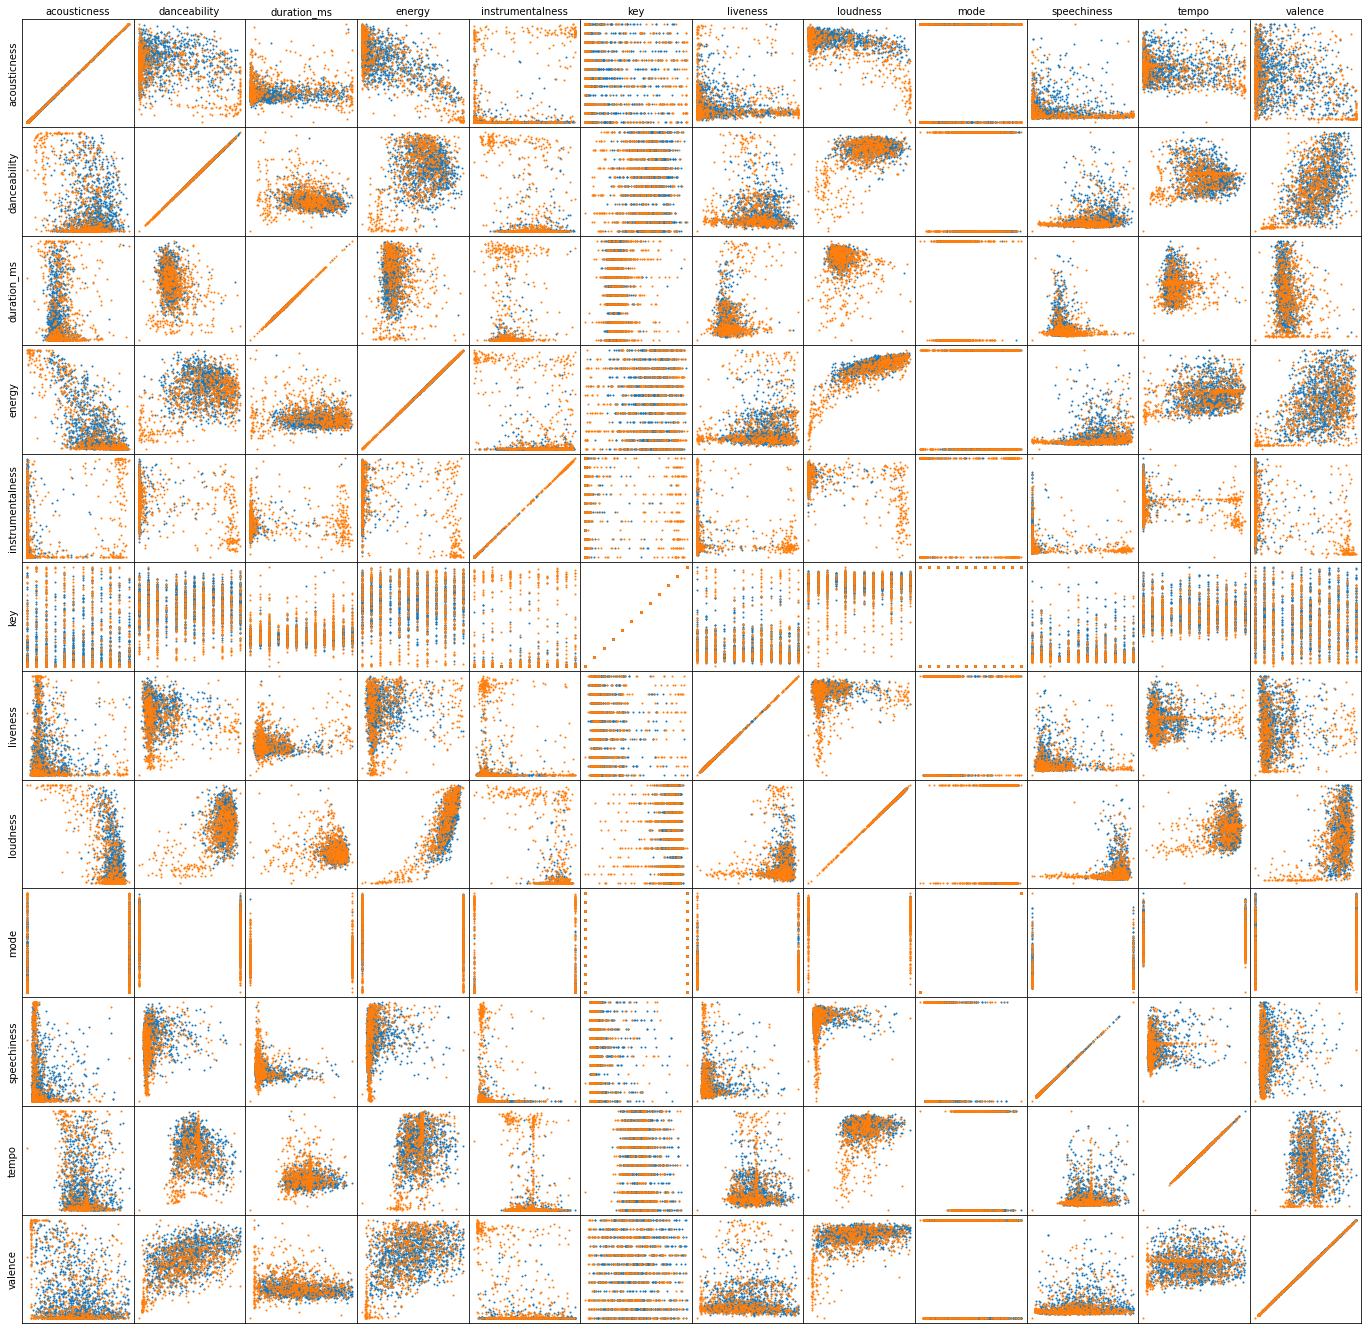

In [19]:
columns = training_df.columns[:-1]

fig, axes = plt.subplots(len(columns), len(columns), figsize=(len(columns) * 2, len(columns) * 2))
for i, col_i in enumerate(columns):
    for j, col_j in enumerate(columns):
        ax = axes[j, i]
        ax.scatter(
            training_df.loc[training_df['rating'] == 1][col_j], 
            training_df.loc[training_df['rating'] == 1][col_i], 
            s=1, c='tab:blue'
        )
        ax.scatter(
            training_df.loc[training_df['rating'] == 0][col_j], 
            training_df.loc[training_df['rating'] == 0][col_i], 
            s=1, c='tab:orange'
        )
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_yticklabels([])
        if i == 0:
            ax.set_ylabel(col_j)
        if j == 0:
            ax.set_xlabel(col_i)
            ax.xaxis.set_label_position('top') 
plt.subplots_adjust(wspace=0, hspace=0)

Number of components for 95% variance: 10


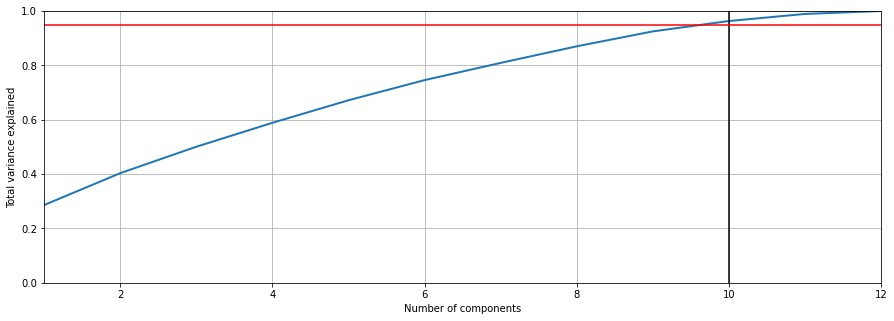

In [20]:
X_train = training_df.drop('rating', axis=1)
y_train = training_df['rating']

X_scaled = StandardScaler().fit_transform(X_train)
pca = decomposition.PCA().fit(X_scaled)

variance_ratio = pca.explained_variance_ratio_
cum_var = np.cumsum(variance_ratio)
threshold = 0.95
n_components = next(i for i, v in enumerate(cum_var) if v > threshold) + 1
print(f"Number of components for {threshold*100:.0f}% variance: {n_components}")

plt.figure(figsize=(15,5))
plt.plot(range(1,13), cum_var, lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total variance explained')
plt.xlim(1, 12)
plt.ylim(0, 1)
plt.grid()
plt.axvline(n_components, c='k')
plt.axhline(threshold, c='r')


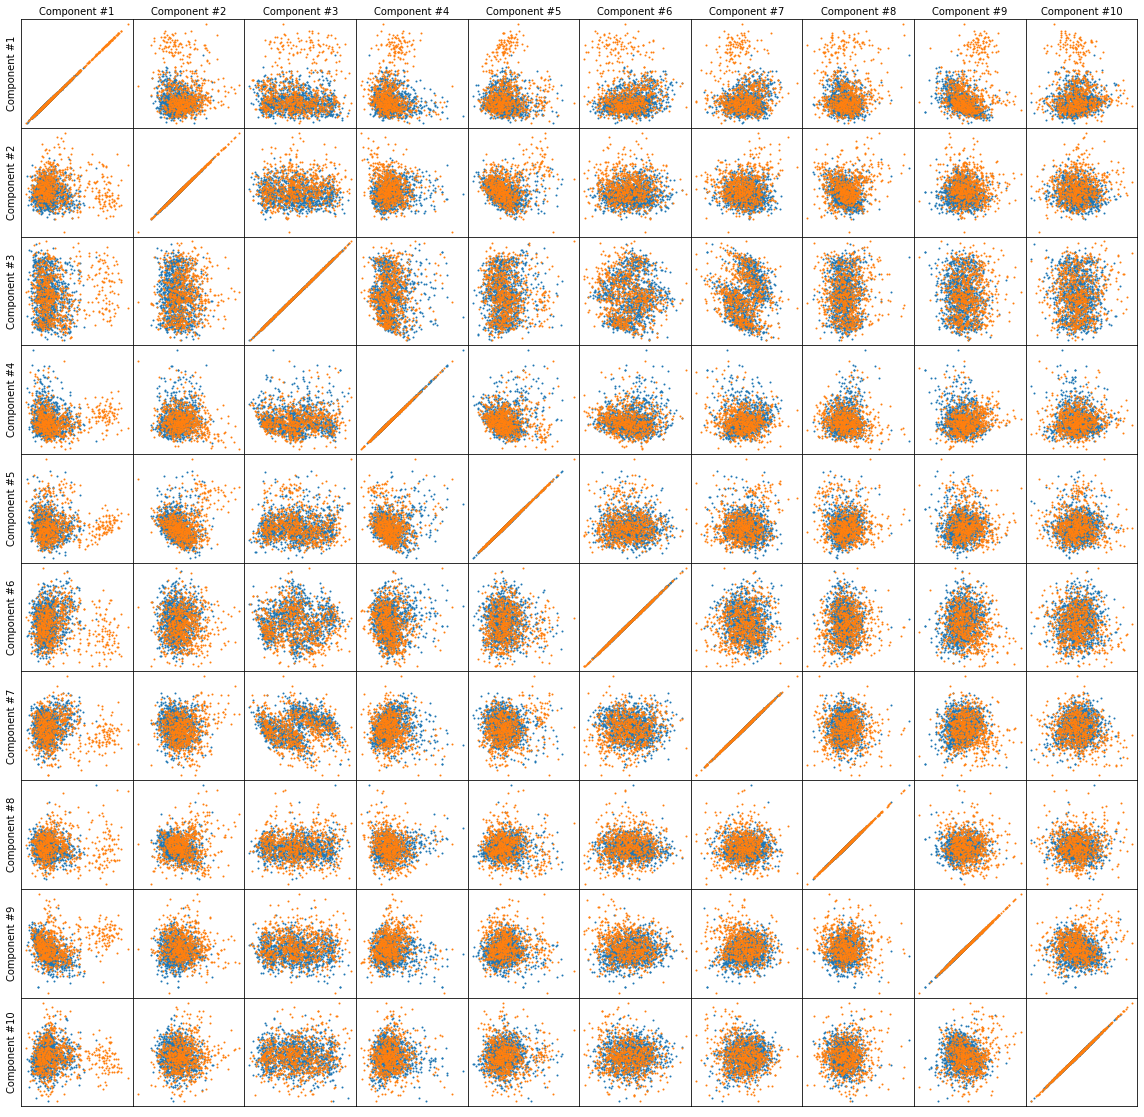

In [21]:
# Fit your dataset to the optimal pca
pca = decomposition.PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(n_components, n_components, figsize=(n_components*2, n_components*2))
for i in range(n_components):
    for j in range(n_components):
        ax = axes[j, i]
        ax.scatter(X_train_pca[y_train == 1][:, i], X_train_pca[y_train == 1][:, j], c='tab:blue', s=1)
        ax.scatter(X_train_pca[y_train == 0][:, i], X_train_pca[y_train == 0][:, j], c='tab:orange', s=1)
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_yticklabels([])
        if i == 0:
            ax.set_ylabel(f"Component #{j + 1}")
        if j == 0:
            ax.set_xlabel(f"Component #{i + 1}")
            ax.xaxis.set_label_position('top') 
plt.subplots_adjust(wspace=0, hspace=0)

In [22]:
v = TfidfVectorizer(sublinear_tf=True, ngram_range=(1, 6), max_features=10000)
X_names_sparse = v.fit_transform(track_names)
X_names_sparse.shape

X_train = sparse.csr_matrix(sparse.hstack([X_train_pca, X_names_sparse]))
X_train.shape

(1925, 10010)

## Training

In [23]:
# K-nearest neighbor classification
n_splits = 5
max_neighbors = 50

skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

knc_params = {'n_neighbors': range(1, max_neighbors + 1)}
knc = KNeighborsClassifier(n_jobs=-1)

knc_grid = GridSearchCV(knc, knc_params, n_jobs=-1, cv=skf, verbose=1)
knc_grid.fit(X_train, y_train)
print("Best score: ", knc_grid.best_score_)

grid_results = pd.DataFrame(knc_grid.cv_results_)
grid_results

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best score:  0.7361038961038961


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001144,0.000566,0.039218,0.002039,1,{'n_neighbors': 1},0.659740,0.696104,0.636364,0.670130,0.662338,0.664935,0.019228,49
1,0.000832,0.000037,0.042739,0.013552,2,{'n_neighbors': 2},0.667532,0.685714,0.594805,0.649351,0.615584,0.642597,0.033287,50
2,0.000759,0.000127,0.037403,0.003378,3,{'n_neighbors': 3},0.709091,0.724675,0.670130,0.709091,0.703896,0.703377,0.018025,47
3,0.000655,0.000038,0.028159,0.003966,4,{'n_neighbors': 4},0.693506,0.724675,0.636364,0.706494,0.680519,0.688312,0.029797,48
4,0.000637,0.000032,0.032984,0.004547,5,{'n_neighbors': 5},0.711688,0.755844,0.677922,0.750649,0.711688,0.721558,0.028708,44
5,0.000655,0.000029,0.030435,0.004791,6,{'n_neighbors': 6},0.714286,0.732468,0.667532,0.748052,0.709091,0.714286,0.027143,46
6,0.000639,0.000036,0.034043,0.003363,7,{'n_neighbors': 7},0.714286,0.737662,0.680519,0.753247,0.727273,0.722597,0.024608,42
7,0.000645,0.000022,0.023385,0.002518,8,{'n_neighbors': 8},0.701299,0.714286,0.680519,0.748052,0.729870,0.714805,0.023197,45
8,0.000641,0.000014,0.029329,0.003735,9,{'n_neighbors': 9},0.706494,0.745455,0.709091,0.750649,0.729870,0.728312,0.018115,20
9,0.000791,0.000261,0.031275,0.005872,10,{'n_neighbors': 10},0.711688,0.742857,0.693506,0.758442,0.740260,0.729351,0.023429,15


(0.0, 50.0)

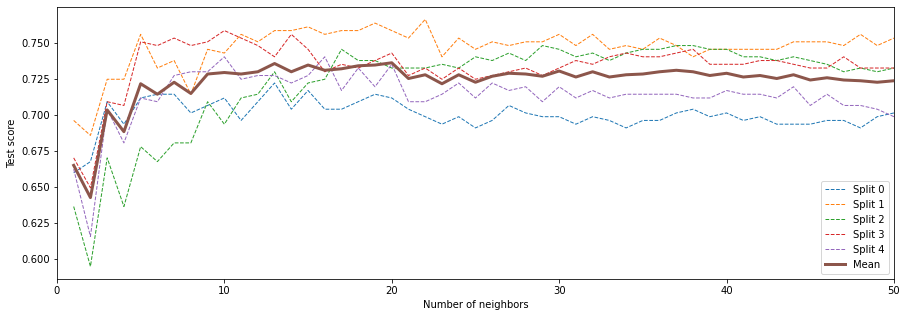

In [24]:
plt.figure(figsize=(15, 5))
for n in range(n_splits):
    plt.plot(grid_results['param_n_neighbors'], grid_results[f'split{n}_test_score'], label=f'Split {n}', ls='--', lw=1)
plt.plot(grid_results['param_n_neighbors'], grid_results['mean_test_score'], label='Mean', lw=3)
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Test score')
plt.xlim(0, max_neighbors)

In [25]:
# Random Forest classification

rfc_parameters = {
    'max_features': [4, 6, 8, 10], 
    'min_samples_leaf': [1, 3, 5, 7],
    'max_depth': [3, 5, 7]
}
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True)
forest_grid = GridSearchCV(rfc, rfc_parameters, n_jobs=-1, cv=skf, verbose=1)
forest_grid.fit(X_train, y_train)
print("Best score: ", forest_grid.best_score_)

grid_results = pd.DataFrame(forest_grid.cv_results_)
grid_results

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best score:  0.6233766233766234


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.127668,0.006987,0.021134,0.004801,3,4,1,"{'max_depth': 3, 'max_feat...",0.607792,0.607792,0.607792,0.607792,0.605195,0.607273,0.001039,9
1,0.124956,0.012555,0.017237,0.006297,3,4,3,"{'max_depth': 3, 'max_feat...",0.607792,0.607792,0.607792,0.607792,0.605195,0.607273,0.001039,9
2,0.130376,0.009405,0.013179,0.003203,3,4,5,"{'max_depth': 3, 'max_feat...",0.607792,0.607792,0.607792,0.607792,0.605195,0.607273,0.001039,9
3,0.137337,0.011948,0.017143,0.005857,3,4,7,"{'max_depth': 3, 'max_feat...",0.607792,0.607792,0.607792,0.607792,0.605195,0.607273,0.001039,9
4,0.138239,0.010691,0.013905,0.004551,3,6,1,"{'max_depth': 3, 'max_feat...",0.607792,0.607792,0.607792,0.607792,0.605195,0.607273,0.001039,9
5,0.131118,0.011119,0.016983,0.001594,3,6,3,"{'max_depth': 3, 'max_feat...",0.607792,0.607792,0.607792,0.607792,0.605195,0.607273,0.001039,9
6,0.118171,0.006418,0.019910,0.002696,3,6,5,"{'max_depth': 3, 'max_feat...",0.607792,0.607792,0.607792,0.607792,0.605195,0.607273,0.001039,9
7,0.117045,0.009414,0.024061,0.005447,3,6,7,"{'max_depth': 3, 'max_feat...",0.607792,0.607792,0.607792,0.607792,0.605195,0.607273,0.001039,9
8,0.123209,0.005019,0.021550,0.003927,3,8,1,"{'max_depth': 3, 'max_feat...",0.607792,0.607792,0.607792,0.607792,0.605195,0.607273,0.001039,9
9,0.126167,0.013609,0.042292,0.024265,3,8,3,"{'max_depth': 3, 'max_feat...",0.607792,0.607792,0.607792,0.607792,0.605195,0.607273,0.001039,9


([], [])

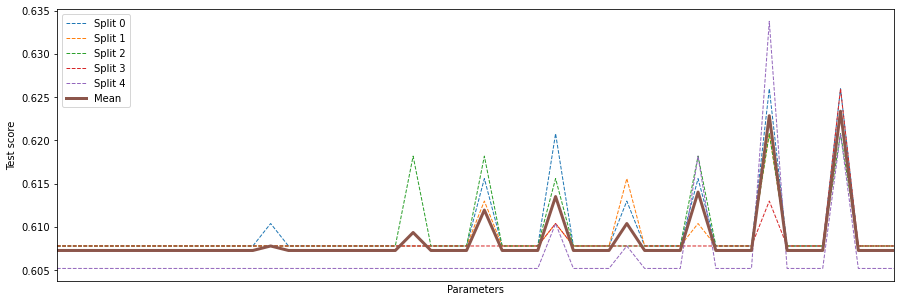

In [26]:
plt.figure(figsize=(15, 5))
for n in range(n_splits):
    plt.plot(grid_results[f'split{n}_test_score'], label=f'Split {n}', ls='--', lw=1)
plt.plot(grid_results['mean_test_score'], label='Mean', lw=3)
plt.legend()
plt.xlabel('Parameters')
plt.ylabel('Test score')
plt.xlim(0, len(grid_results.index) - 1)
plt.xticks([])

In [27]:
# Decision tree classification

tree_parameters = {
    'max_depth': range(1,11),
    'max_features': range(4, 11)
}
tree = DecisionTreeClassifier()
tree_grid = GridSearchCV(tree, tree_parameters, cv=skf, n_jobs=-1, verbose=True)
tree_grid.fit(X_train, y_train)
print("Best score: ", tree_grid.best_score_)

grid_results = pd.DataFrame(tree_grid.cv_results_)
grid_results

Fitting 5 folds for each of 70 candidates, totalling 350 fits
Best score:  0.6296103896103895


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001973,0.000531,0.000503,0.000173,1,4,"{'max_depth': 1, 'max_feat...",0.607792,0.607792,0.610390,0.607792,0.610390,0.608831,0.001272,51
1,0.001313,0.000256,0.000368,0.000085,1,5,"{'max_depth': 1, 'max_feat...",0.607792,0.612987,0.607792,0.607792,0.605195,0.608312,0.002545,55
2,0.001139,0.000065,0.000351,0.000085,1,6,"{'max_depth': 1, 'max_feat...",0.607792,0.607792,0.607792,0.607792,0.605195,0.607273,0.001039,64
3,0.001028,0.000136,0.000300,0.000077,1,7,"{'max_depth': 1, 'max_feat...",0.607792,0.607792,0.607792,0.612987,0.605195,0.608312,0.002545,55
4,0.000898,0.000151,0.000229,0.000019,1,8,"{'max_depth': 1, 'max_feat...",0.607792,0.607792,0.607792,0.607792,0.605195,0.607273,0.001039,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,0.001167,0.000076,0.000217,0.000015,10,6,"{'max_depth': 10, 'max_fea...",0.607792,0.620779,0.628571,0.623377,0.610390,0.618182,0.007878,9
66,0.001360,0.000120,0.000287,0.000069,10,7,"{'max_depth': 10, 'max_fea...",0.646753,0.612987,0.607792,0.612987,0.607792,0.617662,0.014730,12
67,0.001283,0.000128,0.000240,0.000033,10,8,"{'max_depth': 10, 'max_fea...",0.615584,0.618182,0.620779,0.618182,0.612987,0.617143,0.002649,15
68,0.001289,0.000156,0.000232,0.000012,10,9,"{'max_depth': 10, 'max_fea...",0.610390,0.618182,0.625974,0.607792,0.636364,0.619740,0.010467,5


([], [])

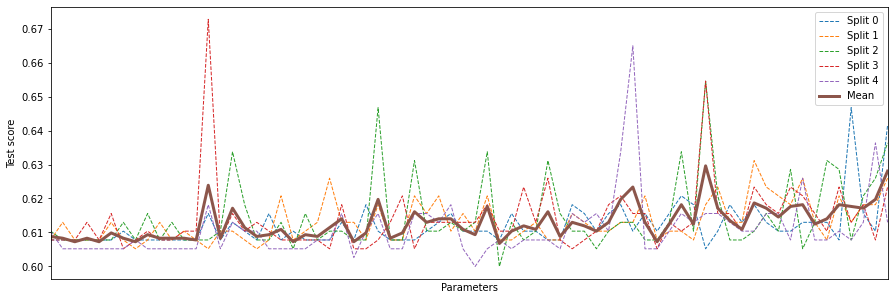

In [28]:
plt.figure(figsize=(15, 5))
for n in range(n_splits):
    plt.plot(grid_results[f'split{n}_test_score'], label=f'Split {n}', ls='--', lw=1)
plt.plot(grid_results['mean_test_score'], label='Mean', lw=3)
plt.legend()
plt.xlabel('Parameters')
plt.ylabel('Test score')
plt.xlim(0, len(grid_results.index) - 1)
plt.xticks([])

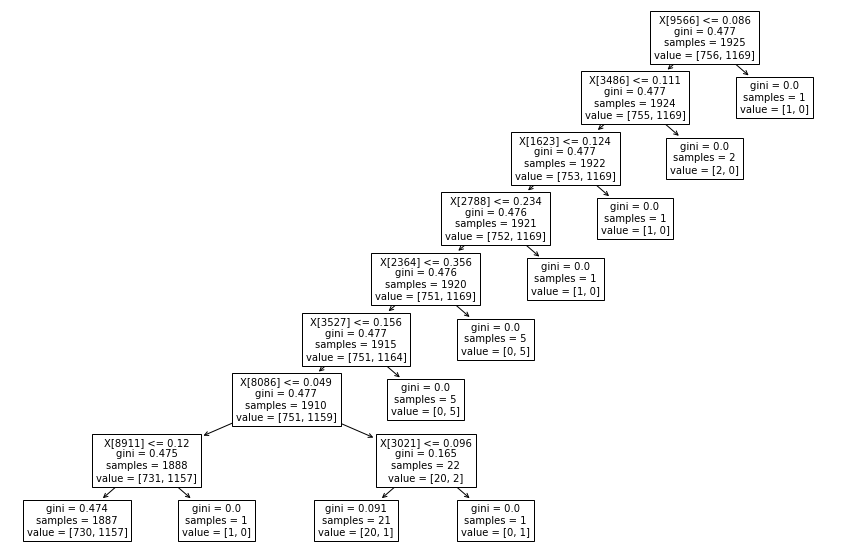

In [29]:
plt.figure(figsize=(15, 10))
plot_tree(tree_grid.best_estimator_, fontsize=10)
print()

## Testing

In [30]:
rec_tracks_per_track = 2
max_rec_tracks = 2000
rec_tracks_per_track = min([max_rec_tracks, len(favorites_df['id']) * rec_tracks_per_track]) // len(favorites_df['id'])
print(f"Using {rec_tracks_per_track} test tracks per track")

rec_tracks = []
for i in favorites_df['id']:
    try:
        rec_tracks.extend(spotify.recommendations(seed_tracks=[i], limit=rec_tracks_per_track)['tracks'])
    except:
        break

Using 1 test tracks per track


In [35]:
rec_tracks[0]

{'album': {'album_type': 'ALBUM',
  'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/2xiIXseIJcq3nG7C8fHeBj'},
    'href': 'https://api.spotify.com/v1/artists/2xiIXseIJcq3nG7C8fHeBj',
    'id': '2xiIXseIJcq3nG7C8fHeBj',
    'name': 'Three Days Grace',
    'type': 'artist',
    'uri': 'spotify:artist:2xiIXseIJcq3nG7C8fHeBj'}],
  'available_markets': ['AD',
   'AE',
   'AL',
   'AM',
   'AO',
   'AT',
   'AU',
   'AZ',
   'BA',
   'BE',
   'BF',
   'BG',
   'BH',
   'BI',
   'BJ',
   'BW',
   'BY',
   'CD',
   'CG',
   'CH',
   'CI',
   'CM',
   'CV',
   'CW',
   'CY',
   'CZ',
   'DE',
   'DJ',
   'DK',
   'DZ',
   'EE',
   'EG',
   'ES',
   'FI',
   'FR',
   'GA',
   'GB',
   'GE',
   'GH',
   'GM',
   'GN',
   'GQ',
   'GR',
   'GW',
   'HR',
   'HU',
   'IE',
   'IL',
   'IQ',
   'IS',
   'IT',
   'JO',
   'KE',
   'KG',
   'KI',
   'KM',
   'KW',
   'KZ',
   'LB',
   'LI',
   'LR',
   'LS',
   'LT',
   'LU',
   'LV',
   'LY',
   'MA',
   'MC',
   'MD',
   '

In [37]:
len(rec_tracks)

1611

In [38]:
rec_track_ids = []
rec_track_names = []
for i in rec_tracks[:10]:
    rec_track_ids.append(i['id'])
    rec_track_names.append(i['name'])

rec_features = get_features(rec_track_ids)
        
rec_playlist_df = pd.DataFrame(rec_features, index=rec_track_names)
rec_playlist_df.drop_duplicates(subset='id', inplace=True)
rec_track_names = rec_playlist_df.index.tolist()
rec_playlist_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
Never Too Late,0.433,0.778,2,-4.680,0,0.0371,0.008380,0.000000,0.1630,0.217,149.864,audio_features,5y7NRMui3GLbwj2zBaOqo1,spotify:track:5y7NRMui3GLb...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,209333,4
Sjæl I Flammer,0.725,0.577,8,-15.198,1,0.0417,0.106000,0.001690,0.3770,0.847,115.653,audio_features,5J4Sv344YHnQasAgmfSorL,spotify:track:5J4Sv344YHnQ...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,187107,4
Poison,0.280,0.908,2,-5.509,0,0.1090,0.032700,0.000009,0.1800,0.260,118.698,audio_features,5XcZRgJv3zMhTqCyESjQrF,spotify:track:5XcZRgJv3zMh...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,270080,4
Shyboy (Timido),0.484,0.888,5,-14.087,1,0.1100,0.025300,0.000002,0.5570,0.426,128.369,audio_features,2ZnqBtgjvjgM29xYRMs1C2,spotify:track:2ZnqBtgjvjgM...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,204493,4
Balls To The Wall,0.357,0.810,9,-9.378,0,0.0559,0.000673,0.016100,0.9780,0.246,115.434,audio_features,0xX1PxiAPN1mD9hCRiqd0Z,spotify:track:0xX1PxiAPN1m...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,619133,4
Better Together,0.871,0.346,5,-9.481,1,0.0522,0.298000,0.000009,0.1080,0.659,110.054,audio_features,2iXdwVdzA0KrI2Q0iZNJbX,spotify:track:2iXdwVdzA0Kr...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,207680,4
"This Is Not a Song, It's a Sandwich",0.625,0.826,6,-6.091,1,0.1390,0.000482,0.007400,0.0945,0.567,98.423,audio_features,0EdL74JcmrL0FNIIyh1UFV,spotify:track:0EdL74JcmrL0...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,233027,4
"Faithfully - Live at The Budokan, Tokyo, Japan, March 2, 1983",0.314,0.523,11,-6.757,1,0.0287,0.220000,0.000091,0.4170,0.225,131.832,audio_features,02YK6O21sarkT8HhAxrVt6,spotify:track:02YK6O21sark...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,259520,4
The Passenger,0.500,0.846,0,-8.098,1,0.0457,0.079700,0.000000,0.2410,0.738,134.937,audio_features,24FmdHoCr2jZGE6Z6dZbJT,spotify:track:24FmdHoCr2jZ...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,284067,4
Inside Out,0.483,0.818,11,-7.666,1,0.0444,0.114000,0.000000,0.3670,0.691,175.668,audio_features,4GiVcDqNQI0fc0yYuRGH9m,spotify:track:4GiVcDqNQI0f...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,219467,4


In [39]:
testing_df = rec_playlist_df[
    [
        "acousticness", "danceability", "duration_ms", "energy", 
        "instrumentalness",  "key", "liveness", "loudness", "mode", 
        "speechiness", "tempo", "valence"
    ]
]
testing_df

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
Never Too Late,0.008380,0.433,209333,0.778,0.000000,2,0.1630,-4.680,0,0.0371,149.864,0.217
Sjæl I Flammer,0.106000,0.725,187107,0.577,0.001690,8,0.3770,-15.198,1,0.0417,115.653,0.847
Poison,0.032700,0.280,270080,0.908,0.000009,2,0.1800,-5.509,0,0.1090,118.698,0.260
Shyboy (Timido),0.025300,0.484,204493,0.888,0.000002,5,0.5570,-14.087,1,0.1100,128.369,0.426
Balls To The Wall,0.000673,0.357,619133,0.810,0.016100,9,0.9780,-9.378,0,0.0559,115.434,0.246
Better Together,0.298000,0.871,207680,0.346,0.000009,5,0.1080,-9.481,1,0.0522,110.054,0.659
"This Is Not a Song, It's a Sandwich",0.000482,0.625,233027,0.826,0.007400,6,0.0945,-6.091,1,0.1390,98.423,0.567
"Faithfully - Live at The Budokan, Tokyo, Japan, March 2, 1983",0.220000,0.314,259520,0.523,0.000091,11,0.4170,-6.757,1,0.0287,131.832,0.225
The Passenger,0.079700,0.500,284067,0.846,0.000000,0,0.2410,-8.098,1,0.0457,134.937,0.738
Inside Out,0.114000,0.483,219467,0.818,0.000000,11,0.3670,-7.666,1,0.0444,175.668,0.691


In [40]:
estimators = [knc_grid, forest_grid, tree_grid]

testing_df_scaled = StandardScaler().fit_transform(testing_df)

X_test = pca.transform(testing_df_scaled)
X_test_names = v.transform(rec_track_names)

X_test = sparse.csr_matrix(sparse.hstack([X_test, X_test_names]))
y_pred_final = np.array([1] * X_test_names.shape[0])

for estimator in estimators:
    estimator.best_estimator_.fit(X_train, y_train)
    y_pred = estimator.best_estimator_.predict(X_test)
    
    y_pred_final = y_pred_final * y_pred
    print("Number of disliked tracks by model: ", sum(y_pred == 0))
    print("Number of disliked tracks: ", sum(y_pred_final == 0))
    print("Number of liked tracks: ", sum(y_pred_final == 1))
    print()

Number of disliked tracks by model:  2
Number of disliked tracks:  2
Number of liked tracks:  8

Number of disliked tracks by model:  0
Number of disliked tracks:  2
Number of liked tracks:  8

Number of disliked tracks by model:  0
Number of disliked tracks:  2
Number of liked tracks:  8



In [42]:
print(y_pred_final)

[1 1 1 1 0 0 1 1 1 1]


In [41]:
final_tracks = testing_df[y_pred_final.astype(bool)]
final_tracks

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
Never Too Late,0.008380,0.433,209333,0.778,0.000000,2,0.1630,-4.680,0,0.0371,149.864,0.217
Sjæl I Flammer,0.106000,0.725,187107,0.577,0.001690,8,0.3770,-15.198,1,0.0417,115.653,0.847
Poison,0.032700,0.280,270080,0.908,0.000009,2,0.1800,-5.509,0,0.1090,118.698,0.260
Shyboy (Timido),0.025300,0.484,204493,0.888,0.000002,5,0.5570,-14.087,1,0.1100,128.369,0.426
"This Is Not a Song, It's a Sandwich",0.000482,0.625,233027,0.826,0.007400,6,0.0945,-6.091,1,0.1390,98.423,0.567
"Faithfully - Live at The Budokan, Tokyo, Japan, March 2, 1983",0.220000,0.314,259520,0.523,0.000091,11,0.4170,-6.757,1,0.0287,131.832,0.225
The Passenger,0.079700,0.500,284067,0.846,0.000000,0,0.2410,-8.098,1,0.0457,134.937,0.738
Inside Out,0.114000,0.483,219467,0.818,0.000000,11,0.3670,-7.666,1,0.0444,175.668,0.691
